In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
import pickle as pickle
import glob
import pandas as pd
import numpy as np
import math
import re
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from datetime import datetime
from numba import jit

In [4]:
# basepath= [
#     '/content/drive/My Drive/00_project/05_fly-arena/14_capillary_optogenetics/,
# ]

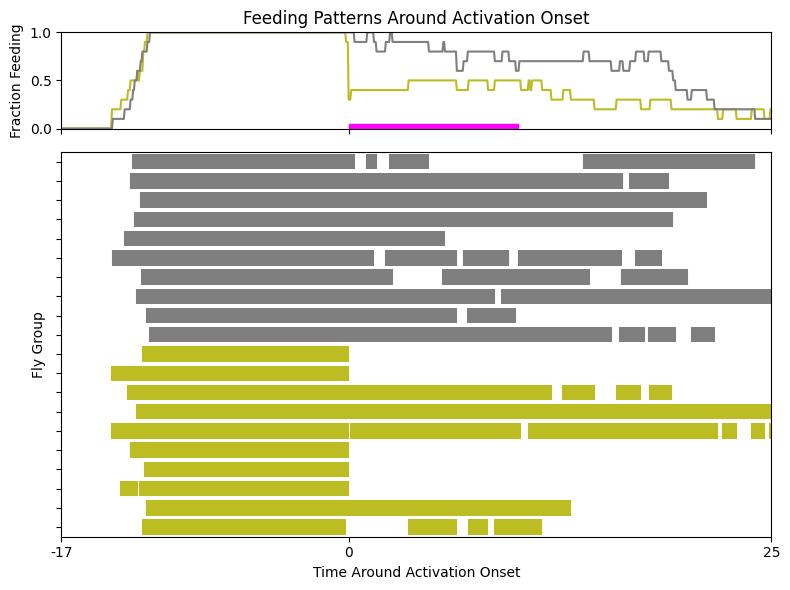

In [11]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

# Base folder and unwanted folder definition
base_folder = '/content/drive/My Drive/00_project/14_capillary_optogenetics/HdcGal4_CsChr_ChaG80/'
unwanted_folder_name = 'ARCHIVE'
group_folders = [os.path.join(base_folder, subfolder) for subfolder in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, subfolder)) and subfolder != unwanted_folder_name]

all_dataframes = []

# Read the data and group it
for group_folder in group_folders:
    files_in_group = [f for f in os.listdir(group_folder) if f.endswith('processed.csv')]

    for filename in files_in_group:
        df = pd.read_csv(os.path.join(group_folder, filename))
        df.columns = ['time', 'latency', 'activation', 'feeding']

        # Round the time to 50ms bins
        df['rounded_time'] = (df['time'] / 0.05).round() * 0.05
        df = df.groupby('rounded_time').agg({'latency': 'first', 'activation': 'max', 'feeding': 'max'}).reset_index()

        df['group'] = os.path.basename(group_folder)
        all_dataframes.append(df)

# Extract data around activation onset
pre_window = 17
post_window = 25
expected_length = int((pre_window + post_window) / 0.05)
aggregated_data = []

for df in all_dataframes:
    activation_time = df.loc[df['activation'], 'rounded_time'].min()

    if pd.notna(activation_time):
        pre_activation = df[(df['rounded_time'] >= activation_time - pre_window) & (df['rounded_time'] < activation_time)]
        post_activation = df[(df['rounded_time'] > activation_time) & (df['rounded_time'] <= activation_time + post_window)]

        while len(pre_activation) + len(post_activation) < expected_length:
            if len(pre_activation) < int(pre_window/0.05):
                new_row = pd.DataFrame({'rounded_time': [pre_activation.iloc[0]['rounded_time'] - 0.05], 'feeding': [0], 'activation': [0], 'latency': [np.nan]})
                pre_activation = pd.concat([new_row, pre_activation]).reset_index(drop=True)
            else:
                new_row = pd.DataFrame({'rounded_time': [post_activation.iloc[-1]['rounded_time'] + 0.05], 'feeding': [0], 'activation': [0], 'latency': [np.nan]})
                post_activation = pd.concat([post_activation, new_row]).reset_index(drop=True)

        window_data = pd.concat([pre_activation, post_activation])
        aggregated_data.append(window_data)

list_of_arrays = [df['feeding'].values for df in aggregated_data]
data_matrix = np.vstack(list_of_arrays)

# Get the unique groups
unique_groups = list(set(df['group'].iloc[0] for df in all_dataframes))

# Assign a color to each group, cycling between 'cyan' and 'magenta' (or extend the list if you have more groups)
group_colors = {group: color for group, color in zip(unique_groups, ['tab:olive', 'tab:gray'] * len(unique_groups))}

# ... [Previous data processing code]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [1, 4]}, sharex=True)

# Group-wise fraction of feeding plot
grouped_data_matrix = {group: [] for group in unique_groups}
for fly_data, df in zip(list_of_arrays, all_dataframes):
    grouped_data_matrix[df['group'].iloc[0]].append(fly_data)

for group, color in group_colors.items():
    group_matrix = np.array(grouped_data_matrix[group])
    fraction_feeding = group_matrix.sum(axis=0) / group_matrix.shape[0]
    ax1.plot(fraction_feeding, color=color)

ax1.set_ylabel('Fraction Feeding')
ax1.set_ylim(0, 1)
ax1.set_title('Feeding Patterns Around Activation Onset')

# Small rectangle for activation period at the bottom
activation_start = int(pre_window / 0.05)  # assuming activation starts at the end of the pre-window
activation_end = activation_start + int(10 / 0.05)  # activation lasts for 10 seconds
rectangle = patches.Rectangle((activation_start, 0), activation_end - activation_start, 0.05, color='magenta')
ax1.add_patch(rectangle)

# Event plot
for idx, (fly_data, df) in enumerate(zip(list_of_arrays, all_dataframes)):
    event_times = np.where(fly_data == 1)[0]
    ax2.eventplot(event_times, lineoffsets=idx, linelengths=0.8, colors=group_colors[df['group'].iloc[0]])

ax2.set_aspect('auto')
ax2.set_xlim(0, expected_length)
ax2.set_ylim(-0.5, len(list_of_arrays) - 0.5)
ax2.set_xticks([0, int(pre_window/0.05), int(pre_window/0.05) + int(post_window/0.05)])
ax2.set_xticklabels([-pre_window, 0, post_window])
ax2.set_yticks(np.arange(len(aggregated_data)))
# ax2.set_yticklabels([df['group'].iloc[0] for df in aggregated_data])
ax2.set_yticklabels('')
ax2.set_xlabel('Time Around Activation Onset')
ax2.set_ylabel('Fly Group')

plt.tight_layout()
plt.show()
fig.savefig(base_folder + 'output_filename.svg', dpi=300, bbox_inches='tight')


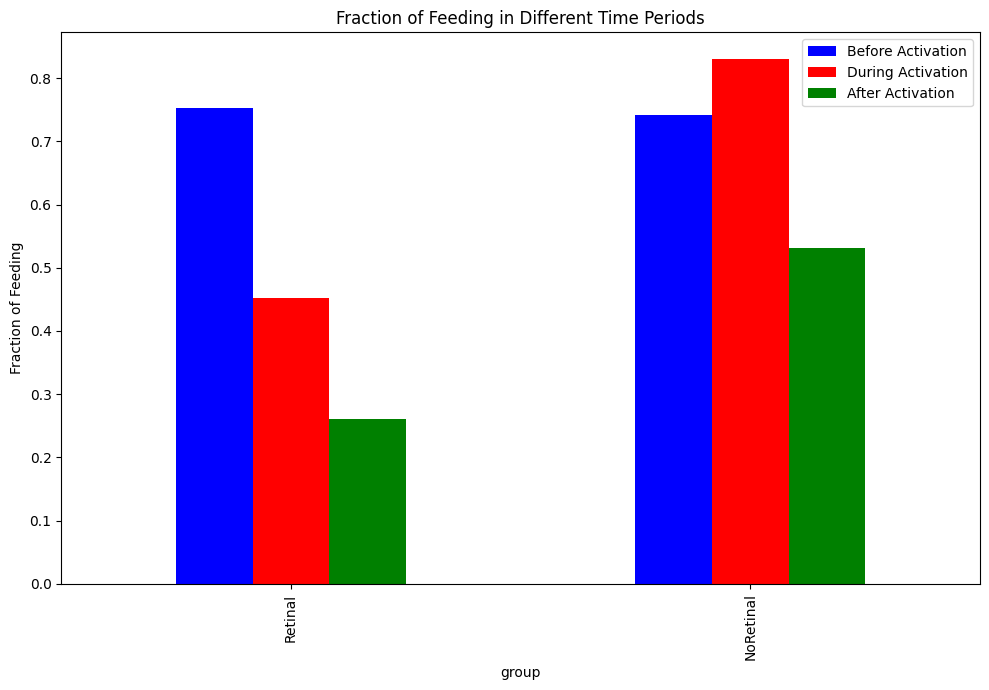

<ipython-input-14-33666b4ecb41>:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x='Period', y='Fraction Feeding', data=melted_fraction_df, hue='group', markers=["o", "s", "D"], linestyles=["-", "--", "-."], ci='sd', join=True, capsize=0.2)
<ipython-input-14-33666b4ecb41>:33: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='Period', y='Fraction Feeding', data=melted_fraction_df, hue='group', markers=["o", "s", "D"], linestyles=["-", "--", "-."], ci='sd', join=True, capsize=0.2)


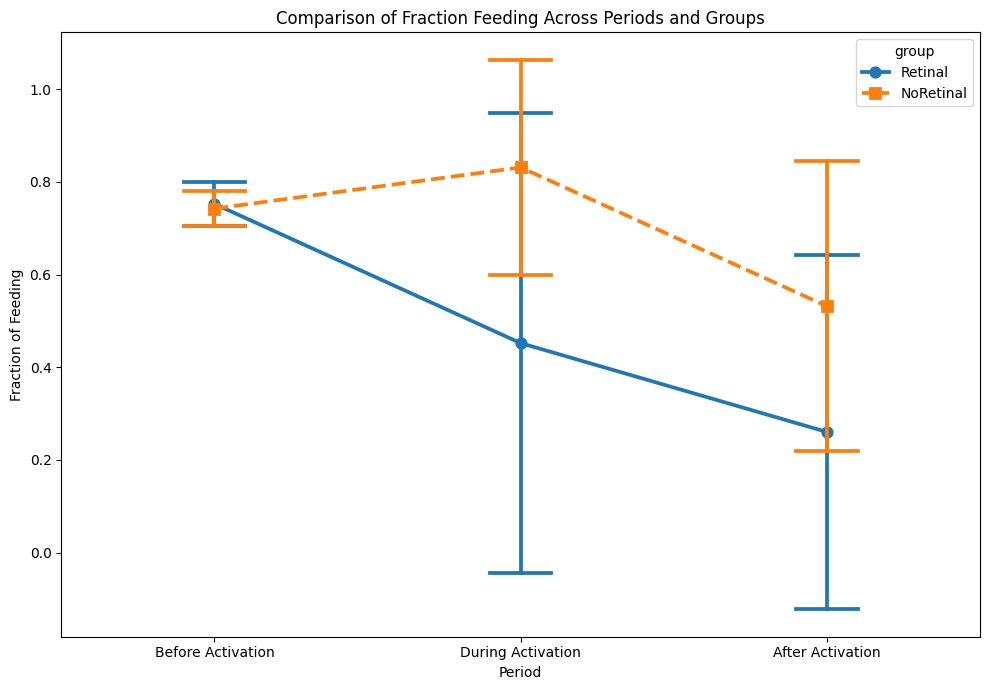

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming fraction_df is already constructed as in previous steps
def fraction_in_period(data, start, end):
    return data[:, start:end].mean(axis=1)

fractions = {
    'Before Activation': fraction_in_period(data_matrix, 0, activation_start),
    'During Activation': fraction_in_period(data_matrix, activation_start, activation_end),
    'After Activation': fraction_in_period(data_matrix, activation_end, expected_length)
}

fraction_df = pd.DataFrame(fractions)
fraction_df['group'] = [df['group'].iloc[0] for df in all_dataframes]

group_order = unique_groups
fraction_df_grouped = fraction_df.groupby('group').mean().reindex(group_order)

fraction_df_grouped.plot(kind='bar', color=['blue', 'red', 'green'], figsize=(10, 7))
plt.ylabel('Fraction of Feeding')
plt.title('Fraction of Feeding in Different Time Periods')
plt.tight_layout()
plt.show()

# Melt the dataframe to be compatible with sns.pointplot
melted_fraction_df = fraction_df.melt(id_vars='group', value_vars=['Before Activation', 'During Activation', 'After Activation'],
                                      var_name='Period', value_name='Fraction Feeding')

# Create a pointplot
plt.figure(figsize=(10, 7))
sns.pointplot(x='Period', y='Fraction Feeding', data=melted_fraction_df, hue='group', markers=["o", "s", "D"], linestyles=["-", "--", "-."], ci='sd', join=True, capsize=0.2)

plt.title('Comparison of Fraction Feeding Across Periods and Groups')
plt.ylabel('Fraction of Feeding')
plt.xlabel('Period')

plt.tight_layout()
plt.show()



In [17]:
fraction_df.to_csv(base_folder + 'output_dataframe.csv')
fraction_df

,Before Activation,During Activation,After Activation,group
0,0.705882,0.535,0.090000,Retinal
1,0.700000,1.000,0.210000,Retinal
2,0.785294,0.000,0.000000,Retinal
3,0.708824,0.000,0.000000,Retinal
4,0.758824,0.000,0.000000,Retinal
5,0.823529,0.985,0.866667,Retinal
6,0.735294,1.000,1.000000,Retinal
7,0.767647,1.000,0.436667,Retinal
8,0.823529,0.000,0.000000,Retinal
9,0.714706,0.000,0.000000,Retinal


<ipython-input-100-eb315eb96d57>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=fraction_long, x='Period', y='Fraction Feeding', hue='group', palette=group_colors, ci='sd')


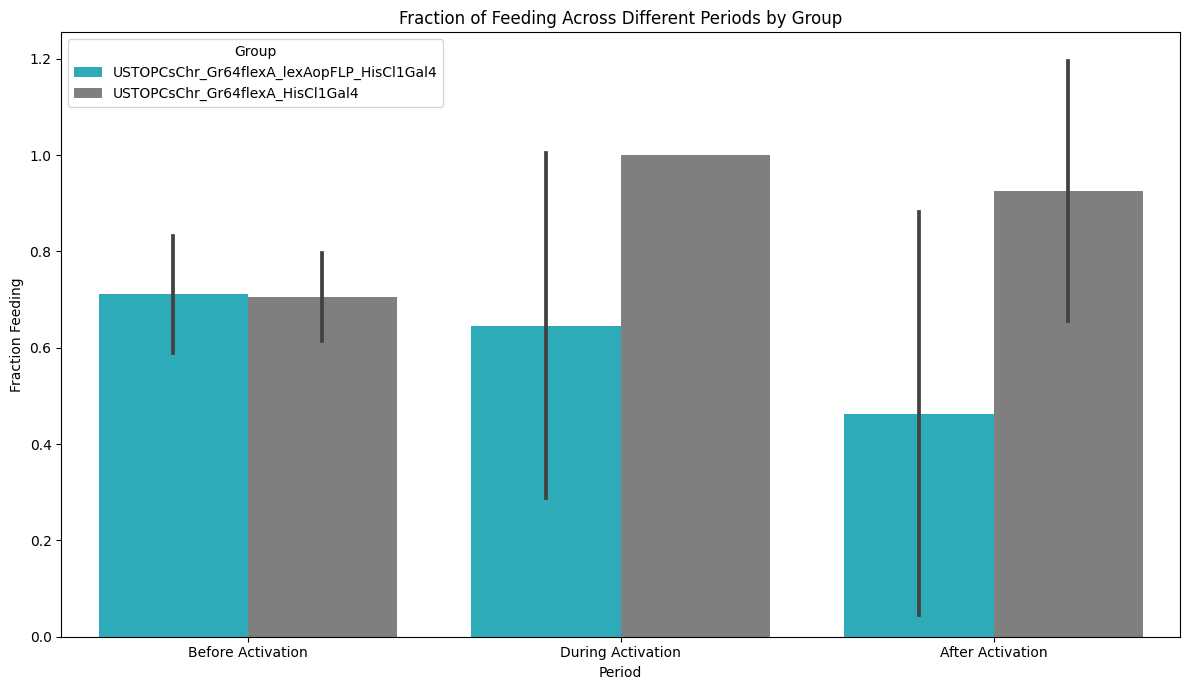

In [ ]:
import seaborn as sns

# Reshape the dataframe for seaborn
fraction_long = fraction_df.melt(id_vars='group', value_vars=['Before Activation', 'During Activation', 'After Activation'],
                                 var_name='Period', value_name='Fraction Feeding')

plt.figure(figsize=(12, 7))
sns.barplot(data=fraction_long, x='Period', y='Fraction Feeding', hue='group', palette=group_colors, ci='sd')
plt.title('Fraction of Feeding Across Different Periods by Group')
plt.legend(title='Group')
plt.tight_layout()
plt.show()


<ipython-input-101-7335a2216070>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=fraction_long, x='Period', y='Fraction Feeding', hue='group', palette=group_colors, ci=None, alpha=0.6)


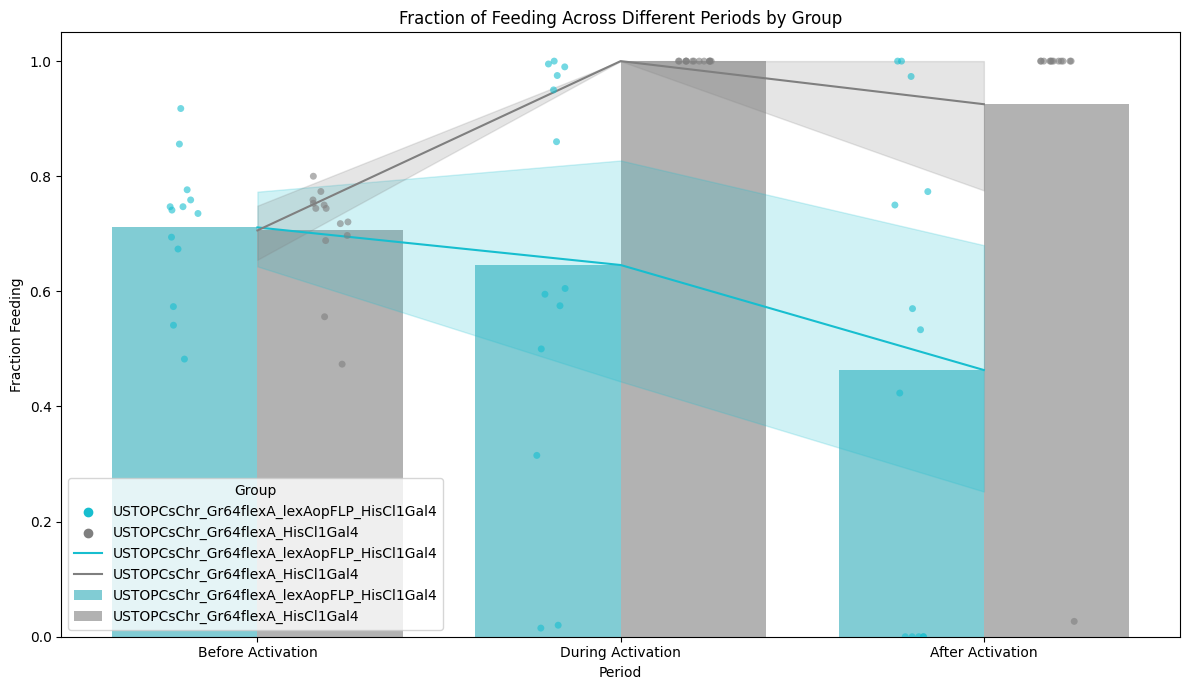

In [ ]:
import seaborn as sns

# Reshape the dataframe for seaborn
fraction_long = fraction_df.melt(id_vars='group', value_vars=['Before Activation', 'During Activation', 'After Activation'],
                                 var_name='Period', value_name='Fraction Feeding')

plt.figure(figsize=(12, 7))

# Barplot for the averages
sns.barplot(data=fraction_long, x='Period', y='Fraction Feeding', hue='group', palette=group_colors, ci=None, alpha=0.6)

# Stripplot for individual data points
sns.stripplot(data=fraction_long, x='Period', y='Fraction Feeding', hue='group', palette=group_colors, dodge=True, jitter=True, marker='o', alpha=0.6)

# Lineplot to connect data points
sns.lineplot(data=fraction_long, x='Period', y='Fraction Feeding', hue='group', palette=group_colors, markers=True, dashes=False)

plt.title('Fraction of Feeding Across Different Periods by Group')
plt.legend(title='Group')
plt.tight_layout()
plt.show()


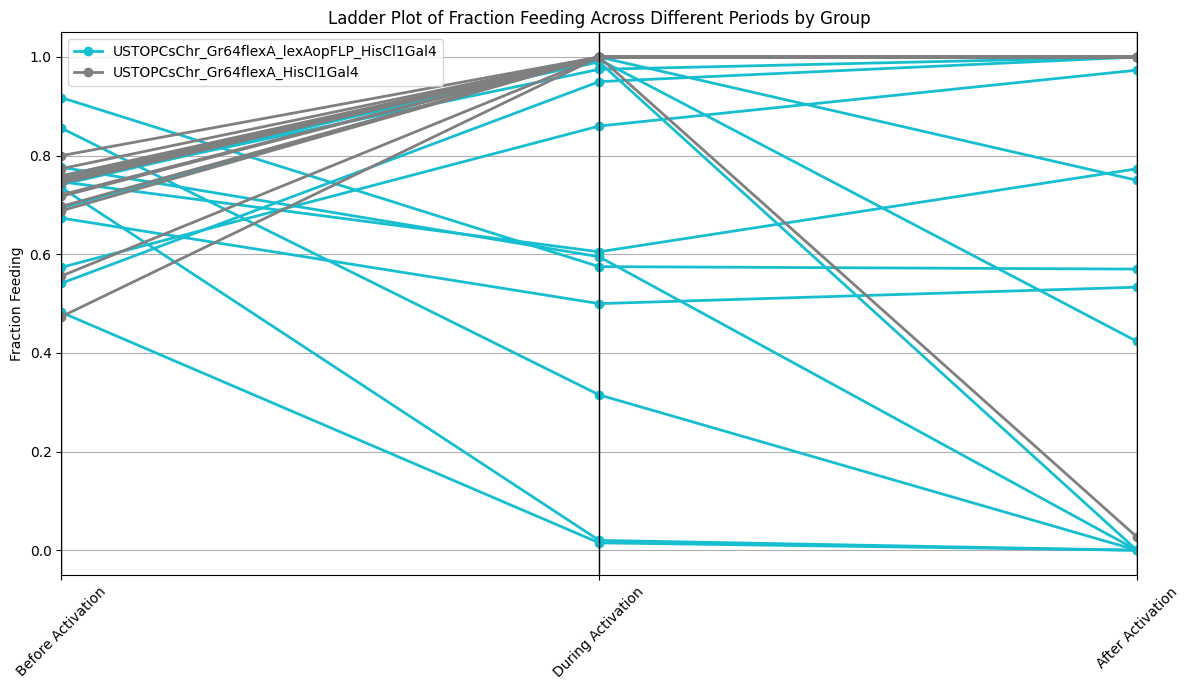

In [ ]:
from pandas.plotting import parallel_coordinates
import matplotlib.lines as mlines

# Assuming fraction_df is already constructed as in previous steps

# Setup for plot aesthetics
plt.figure(figsize=(12, 7))
colors = [group_colors[group] for group in fraction_df['group'].unique()]

# Create the ladder plot
parallel_coordinates(fraction_df, 'group', color=colors, lw=2, marker='o', markersize=6)

# If you wish to have a legend that represents the groups with their corresponding colors
lines = [mlines.Line2D([], [], color=color, marker='o', markersize=6, label=group, lw=2) for group, color in group_colors.items()]
plt.legend(handles=lines)

plt.title('Ladder Plot of Fraction Feeding Across Different Periods by Group')
plt.ylabel('Fraction Feeding')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


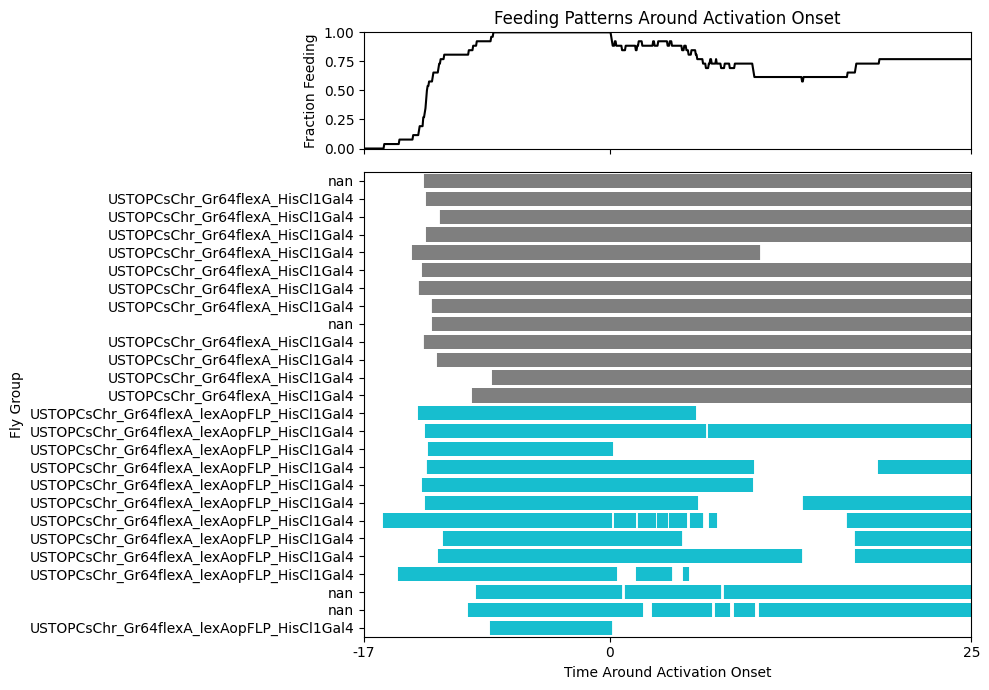

In [ ]:
# ... [Previous data processing code]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [1, 4]}, sharex=True)

# Fraction of feeding plot
fraction_feeding = data_matrix.sum(axis=0) / len(all_dataframes)
ax1.plot(fraction_feeding, color='black')
ax1.set_ylabel('Fraction Feeding')
ax1.set_ylim(0, 1)
ax1.set_title('Feeding Patterns Around Activation Onset')

# Event plot
for idx, (fly_data, df) in enumerate(zip(list_of_arrays, all_dataframes)):
    event_times = np.where(fly_data == 1)[0]
    ax2.eventplot(event_times, lineoffsets=idx, linelengths=0.8, colors=group_colors[df['group'].iloc[0]])

ax2.set_aspect('auto')
ax2.set_xlim(0, expected_length)
ax2.set_ylim(-0.5, len(list_of_arrays) - 0.5)
ax2.set_xticks([0, int(pre_window/0.05), int(pre_window/0.05) + int(post_window/0.05)])
ax2.set_xticklabels([-pre_window, 0, post_window])
ax2.set_yticks(np.arange(len(aggregated_data)))
ax2.set_yticklabels([df['group'].iloc[0] for df in aggregated_data])
ax2.set_xlabel('Time Around Activation Onset')
ax2.set_ylabel('Fly Group')

plt.tight_layout()
plt.show()


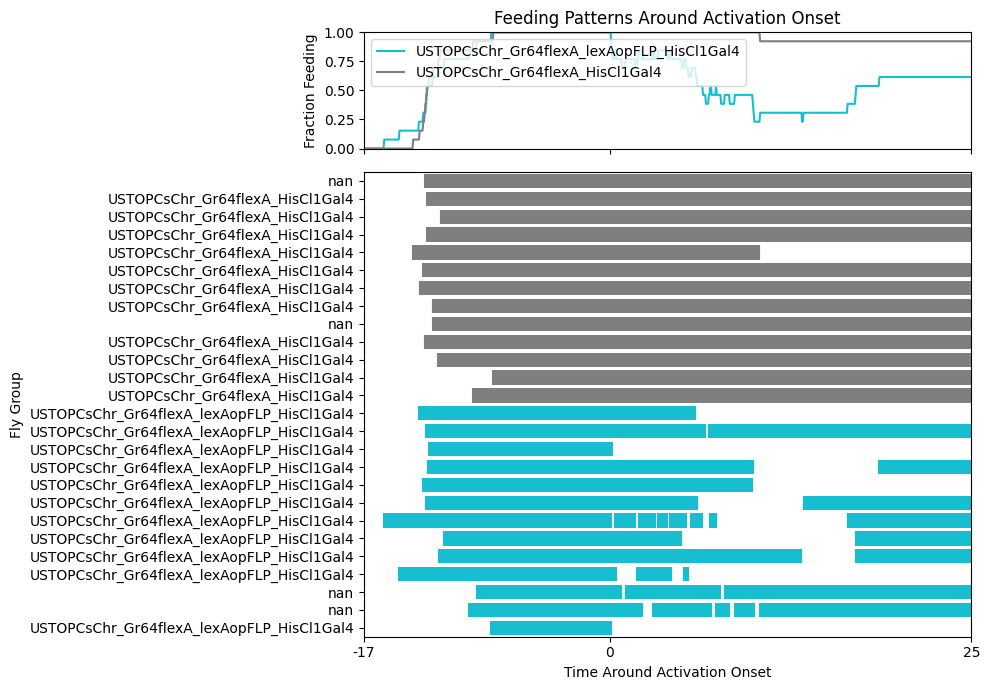

In [ ]:
# ... [Previous data processing code]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [1, 4]}, sharex=True)

# Group-wise fraction of feeding plot
grouped_data_matrix = {group: [] for group in unique_groups}
for fly_data, df in zip(list_of_arrays, all_dataframes):
    grouped_data_matrix[df['group'].iloc[0]].append(fly_data)

for group, color in group_colors.items():
    group_matrix = np.array(grouped_data_matrix[group])
    fraction_feeding = group_matrix.sum(axis=0) / group_matrix.shape[0]
    ax1.plot(fraction_feeding, label=group, color=color)

ax1.set_ylabel('Fraction Feeding')
ax1.set_ylim(0, 1)
ax1.legend(loc="upper left")
ax1.set_title('Feeding Patterns Around Activation Onset')

# Event plot
for idx, (fly_data, df) in enumerate(zip(list_of_arrays, all_dataframes)):
    event_times = np.where(fly_data == 1)[0]
    ax2.eventplot(event_times, lineoffsets=idx, linelengths=0.8, colors=group_colors[df['group'].iloc[0]])

ax2.set_aspect('auto')
ax2.set_xlim(0, expected_length)
ax2.set_ylim(-0.5, len(list_of_arrays) - 0.5)
ax2.set_xticks([0, int(pre_window/0.05), int(pre_window/0.05) + int(post_window/0.05)])
ax2.set_xticklabels([-pre_window, 0, post_window])
ax2.set_yticks(np.arange(len(aggregated_data)))
ax2.set_yticklabels([df['group'].iloc[0] for df in aggregated_data])
ax2.set_xlabel('Time Around Activation Onset')
ax2.set_ylabel('Fly Group')

plt.tight_layout()
plt.show()


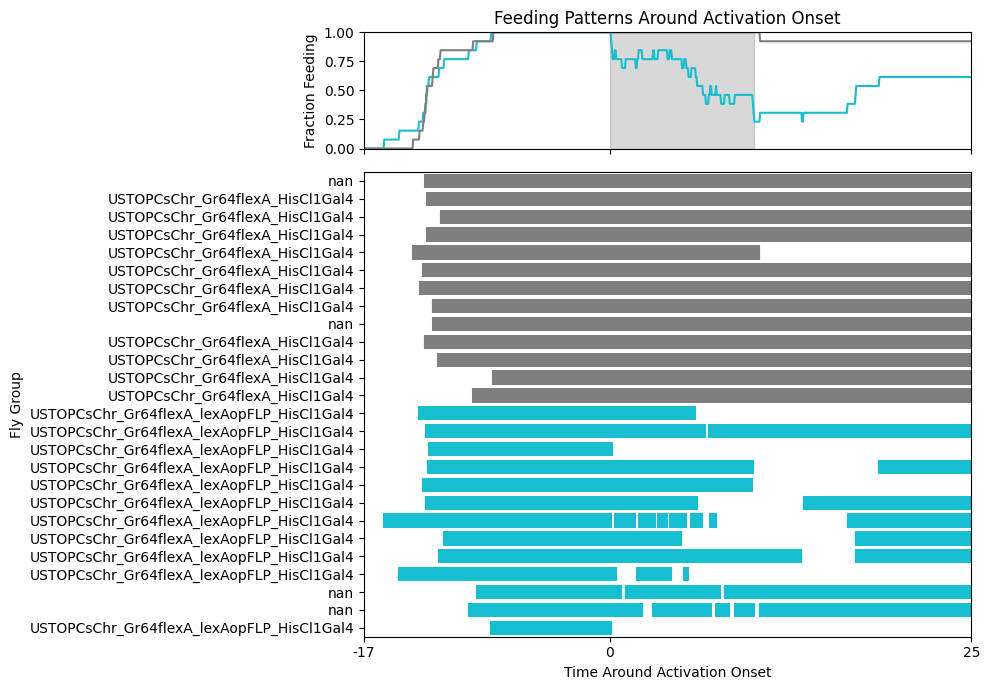

In [ ]:
# ... [Previous data processing code]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [1, 4]}, sharex=True)

# Group-wise fraction of feeding plot
grouped_data_matrix = {group: [] for group in unique_groups}
for fly_data, df in zip(list_of_arrays, all_dataframes):
    grouped_data_matrix[df['group'].iloc[0]].append(fly_data)

for group, color in group_colors.items():
    group_matrix = np.array(grouped_data_matrix[group])
    fraction_feeding = group_matrix.sum(axis=0) / group_matrix.shape[0]
    ax1.plot(fraction_feeding, color=color)

ax1.set_ylabel('Fraction Feeding')
ax1.set_ylim(0, 1)
ax1.set_title('Feeding Patterns Around Activation Onset')

# Shaded area for activation period
activation_start = int(pre_window / 0.05)  # assuming activation starts at the end of the pre-window
activation_end = activation_start + int(10 / 0.05)  # activation lasts for 10 seconds
ax1.axvspan(activation_start, activation_end, color='gray', alpha=0.3)

# Event plot
for idx, (fly_data, df) in enumerate(zip(list_of_arrays, all_dataframes)):
    event_times = np.where(fly_data == 1)[0]
    ax2.eventplot(event_times, lineoffsets=idx, linelengths=0.8, colors=group_colors[df['group'].iloc[0]])

ax2.set_aspect('auto')
ax2.set_xlim(0, expected_length)
ax2.set_ylim(-0.5, len(list_of_arrays) - 0.5)
ax2.set_xticks([0, int(pre_window/0.05), int(pre_window/0.05) + int(post_window/0.05)])
ax2.set_xticklabels([-pre_window, 0, post_window])
ax2.set_yticks(np.arange(len(aggregated_data)))
ax2.set_yticklabels([df['group'].iloc[0] for df in aggregated_data])
ax2.set_xlabel('Time Around Activation Onset')
ax2.set_ylabel('Fly Group')

plt.tight_layout()
plt.show()


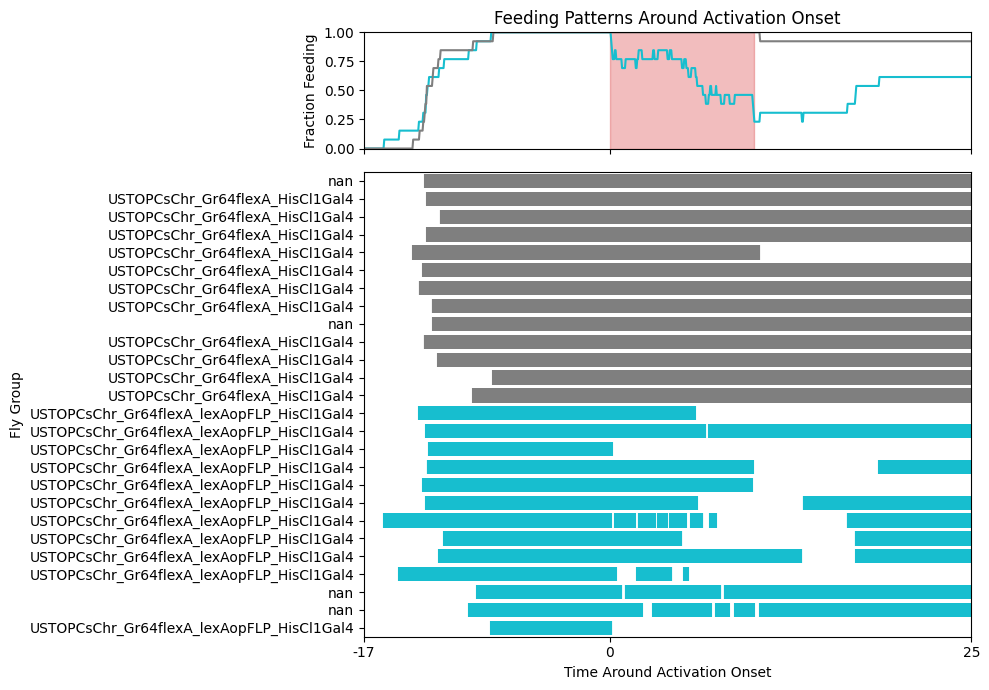

In [ ]:
# ... [Previous data processing code]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [1, 4]}, sharex=True)

# Group-wise fraction of feeding plot
grouped_data_matrix = {group: [] for group in unique_groups}
for fly_data, df in zip(list_of_arrays, all_dataframes):
    grouped_data_matrix[df['group'].iloc[0]].append(fly_data)

for group, color in group_colors.items():
    group_matrix = np.array(grouped_data_matrix[group])
    fraction_feeding = group_matrix.sum(axis=0) / group_matrix.shape[0]
    ax1.plot(fraction_feeding, color=color)

ax1.set_ylabel('Fraction Feeding')
ax1.set_ylim(0, 1)
ax1.set_title('Feeding Patterns Around Activation Onset')

# Shaded area for activation period
activation_start = int(pre_window / 0.05)  # assuming activation starts at the end of the pre-window
activation_end = activation_start + int(10 / 0.05)  # activation lasts for 10 seconds
ax1.axvspan(activation_start, activation_end, color='tab:red', alpha=0.3)

# Event plot
for idx, (fly_data, df) in enumerate(zip(list_of_arrays, all_dataframes)):
    event_times = np.where(fly_data == 1)[0]
    ax2.eventplot(event_times, lineoffsets=idx, linelengths=0.8, colors=group_colors[df['group'].iloc[0]])

ax2.set_aspect('auto')
ax2.set_xlim(0, expected_length)
ax2.set_ylim(-0.5, len(list_of_arrays) - 0.5)
ax2.set_xticks([0, int(pre_window/0.05), int(pre_window/0.05) + int(post_window/0.05)])
ax2.set_xticklabels([-pre_window, 0, post_window])
ax2.set_yticks(np.arange(len(aggregated_data)))
ax2.set_yticklabels([df['group'].iloc[0] for df in aggregated_data])
ax2.set_xlabel('Time Around Activation Onset')
ax2.set_ylabel('Fly Group')

plt.tight_layout()
plt.show()


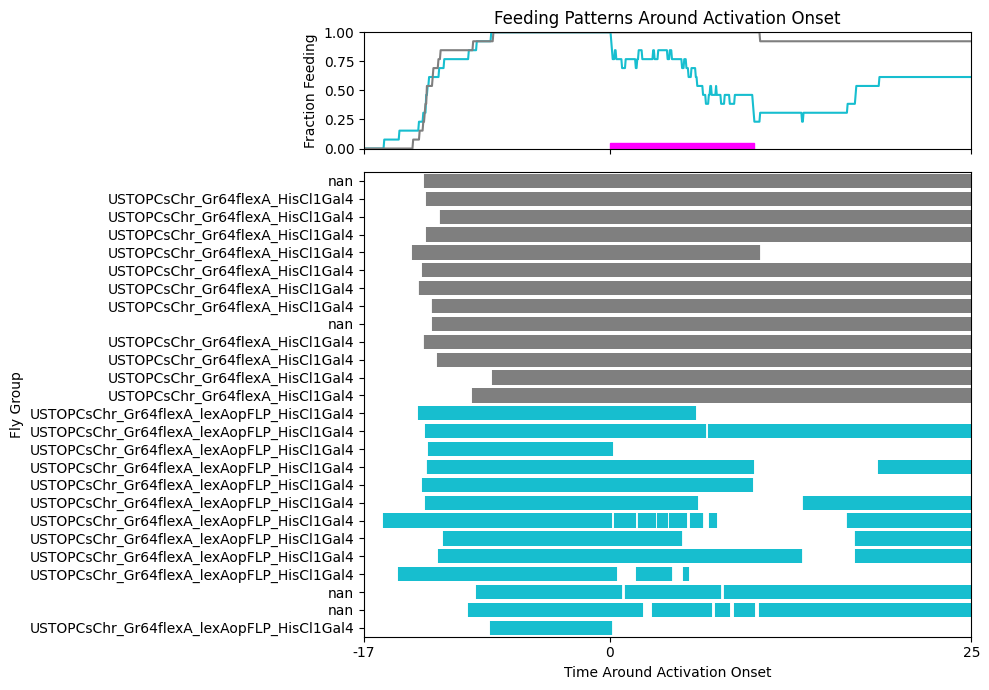

In [ ]:
import matplotlib.patches as patches

# ... [Previous data processing code]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [1, 4]}, sharex=True)

# Group-wise fraction of feeding plot
grouped_data_matrix = {group: [] for group in unique_groups}
for fly_data, df in zip(list_of_arrays, all_dataframes):
    grouped_data_matrix[df['group'].iloc[0]].append(fly_data)

for group, color in group_colors.items():
    group_matrix = np.array(grouped_data_matrix[group])
    fraction_feeding = group_matrix.sum(axis=0) / group_matrix.shape[0]
    ax1.plot(fraction_feeding, color=color)

ax1.set_ylabel('Fraction Feeding')
ax1.set_ylim(0, 1)
ax1.set_title('Feeding Patterns Around Activation Onset')

# Small rectangle for activation period at the bottom
activation_start = int(pre_window / 0.05)  # assuming activation starts at the end of the pre-window
activation_end = activation_start + int(10 / 0.05)  # activation lasts for 10 seconds
rectangle = patches.Rectangle((activation_start, 0), activation_end - activation_start, 0.05, color='magenta')
ax1.add_patch(rectangle)

# Event plot
for idx, (fly_data, df) in enumerate(zip(list_of_arrays, all_dataframes)):
    event_times = np.where(fly_data == 1)[0]
    ax2.eventplot(event_times, lineoffsets=idx, linelengths=0.8, colors=group_colors[df['group'].iloc[0]])

ax2.set_aspect('auto')
ax2.set_xlim(0, expected_length)
ax2.set_ylim(-0.5, len(list_of_arrays) - 0.5)
ax2.set_xticks([0, int(pre_window/0.05), int(pre_window/0.05) + int(post_window/0.05)])
ax2.set_xticklabels([-pre_window, 0, post_window])
ax2.set_yticks(np.arange(len(aggregated_data)))
ax2.set_yticklabels([df['group'].iloc[0] for df in aggregated_data])
ax2.set_xlabel('Time Around Activation Onset')
ax2.set_ylabel('Fly Group')

plt.tight_layout()
plt.show()



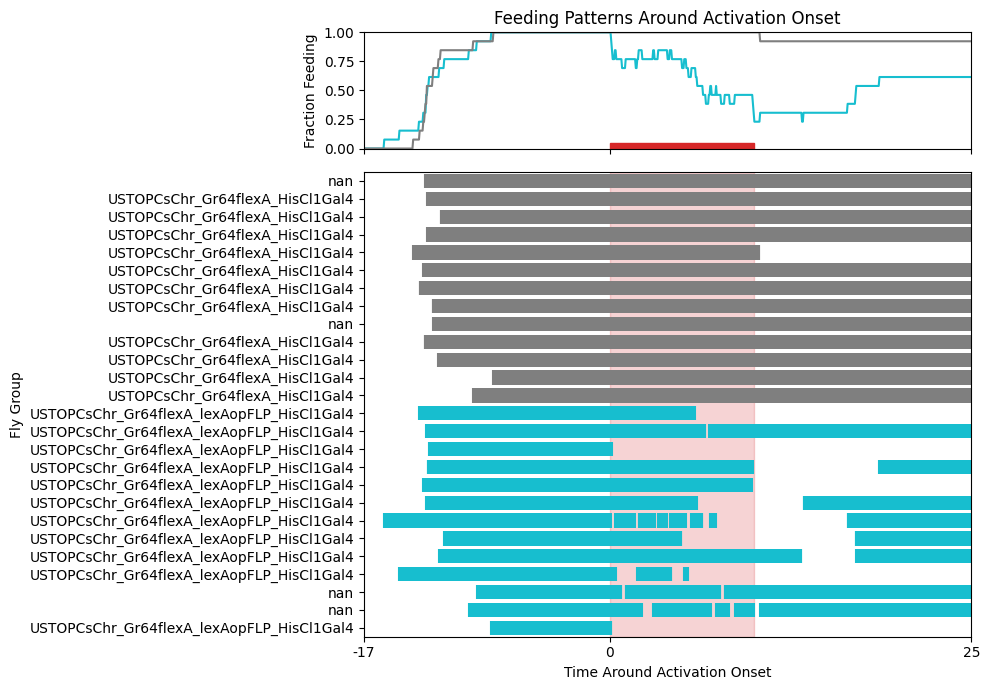

In [ ]:
import matplotlib.patches as patches

# ... [Previous data processing code]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [1, 4]}, sharex=True)

# Group-wise fraction of feeding plot
grouped_data_matrix = {group: [] for group in unique_groups}
for fly_data, df in zip(list_of_arrays, all_dataframes):
    grouped_data_matrix[df['group'].iloc[0]].append(fly_data)

for group, color in group_colors.items():
    group_matrix = np.array(grouped_data_matrix[group])
    fraction_feeding = group_matrix.sum(axis=0) / group_matrix.shape[0]
    ax1.plot(fraction_feeding, color=color)

ax1.set_ylabel('Fraction Feeding')
ax1.set_ylim(0, 1)
ax1.set_title('Feeding Patterns Around Activation Onset')

# Small rectangle for activation period at the bottom in fraction plot
activation_start = int(pre_window / 0.05)  # assuming activation starts at the end of the pre-window
activation_end = activation_start + int(10 / 0.05)  # activation lasts for 10 seconds

fraction_rectangle = patches.Rectangle((activation_start, 0), activation_end - activation_start, 0.05, color='tab:red')
ax1.add_patch(fraction_rectangle)

# Event plot
for idx, (fly_data, df) in enumerate(zip(list_of_arrays, all_dataframes)):
    event_times = np.where(fly_data == 1)[0]
    ax2.eventplot(event_times, lineoffsets=idx, linelengths=0.8, colors=group_colors[df['group'].iloc[0]])

# Rectangle for activation period in event plot
event_rectangle = patches.Rectangle((activation_start, -0.5), activation_end - activation_start, len(list_of_arrays), color='tab:red', alpha=0.2)
ax2.add_patch(event_rectangle)

ax2.set_aspect('auto')
ax2.set_xlim(0, expected_length)
ax2.set_ylim(-0.5, len(list_of_arrays) - 0.5)
ax2.set_xticks([0, int(pre_window/0.05), int(pre_window/0.05) + int(post_window/0.05)])
ax2.set_xticklabels([-pre_window, 0, post_window])
ax2.set_yticks(np.arange(len(aggregated_data)))
ax2.set_yticklabels([df['group'].iloc[0] for df in aggregated_data])
ax2.set_xlabel('Time Around Activation Onset')
ax2.set_ylabel('Fly Group')

plt.tight_layout()
plt.show()

